## Τα Στοιχεία μου
ΤΥΠΑΛΔΟΣ-ΠΑΥΛΟΣ ΑΠΟΣΤΟΛΑΤΟΣ 1115201800009



# Initialisation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import nltk
import re
from gensim.models import Word2Vec
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix,classification_report
from gensim.parsing.preprocessing import remove_stopwords
import urllib.request
from scipy import spatial
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
drive.mount('/content/drive')

import sys, os
from statistics import mean
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from torch.autograd import Variable
from torchtext import legacy
from tqdm import tqdm

path = "/content/drive/MyDrive/AI2/" #update this
#path = "C:/Users/Pavlos/Desktop/AI2/" #update this
quick_execution=False #update this to True to make all epochs of every model to be quick_global_epoch 
quick_global_epoch=30


Mounted at /content/drive


In [4]:
train_df = pd.read_csv(path + "vaccine_train_set.csv",index_col=0)
validation_set = pd.read_csv(path + "vaccine_validation_set.csv",index_col=0) # and this. only those 2 needed to run your own test csv
print(train_df)
print(validation_set)
# print(validation_set.iat[0,0])

                                                   tweet  label
0      Sip N Shop Come thru right now #Marjais #Popul...      0
1      I don't know about you but My family and I wil...      1
2      @MSignorile Immunizations should be mandatory....      2
3      President Obama spoke in favor of vaccination ...      0
4      "@myfoxla: Arizona monitoring hundreds for mea...      0
...                                                  ...    ...
15971  @Salon if u believe the anti-vax nutcases caus...      1
15972  How do you feel about parents who don't #vacci...      0
15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974  Finance Minister: Budget offers room to procur...      0
15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 2 columns]
                                                  tweet  label
0     @user They had a massive surge in with covid d...      1
1     Required vaccines for school: Parents and guar...      0
2     “@KCStar: T



#Σε αντίθεση με την ασκηση 1
δεν εκτελω τις 2 τελευταιες γραμμες γιατι καταργουν χαρακτηριστικα των tweets που συνυπολογιζονται στο κελί 
"Optimisation των λεξεων μας για το Twitter"

γενικα η χρήση αυτου του κελιού είναι up to debate. θεωρητικα θα βοηθήσει το word2vec γιατι θα μετατρέψει το κειμενο με απλες λεξεις για τις οποιες μπόρει να εκπαιδευτεί αλλα θα εμποδίσει το GloVe γιατί του καταργεί την ιδιατερότητα

In [5]:
"""
preprocess-twitter.py

python preprocess-twitter.py "Some random text with #hashtags, @mentions and http://t.co/kdjfkdjf (links). :)"

Script for preprocessing tweets by Romain Paulus
with small modifications by Jeffrey Pennington
with translation to Python by Motoki Wu (github.com/tokestermw)

Translation of Ruby script to create features for GloVe vectors for Twitter data.
http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

this version from gist.github.com/ppope > preprocess_twitter.py

light edits by amackcrane, mostly inspired by the test case given at bottom
"""

import sys
import regex as re

FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " # amackcrane added trailing space


def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\w+", hashtag)  # amackcrane edit
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    #text = re_sub(r"([A-Z]){2,}", allcaps)  # moved below -amackcrane

    # amackcrane additions
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    text = re_sub(r" ([A-Z]){2,} ", allcaps)
    
    return text.lower()

if __name__ == '__main__':
    #_, text = sys.argv  # kaggle envt breaks this -amackcrane
    #if text == "test":
    text = "I TEST alllll kinds of #hashtags and #HASHTAGS, @mentions and 3000 (http://t.co/dkfjkdf). w/ <3 :) haha!!!!!"
    text2 = "TEStiNg some *tough* #CASES" # couple extra tests -amackcrane
    tokens = tokenize(text)
    print(tokens)
    print(tokenize(text2))


i test  <allcaps> al <elong> kinds of <hashtag> hashtags and <hashtag> hashtags <allcaps> , <user> and <number> ( <url> ) . w / <heart> <smile> haha ! <repeat>
testing some *tough* <hashtag> cases <allcaps>


In [6]:
train_df['tweet'] = train_df['tweet'].apply(lambda x: x.lower())
train_df['tweet'] = train_df['tweet'].apply(lambda x: tokenize(x))
# train_df['tweet'] = train_df['tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
# train_df['tweet'] = train_df['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))

validation_set['tweet'] = validation_set['tweet'].apply(lambda x: x.lower())
validation_set['tweet'] = validation_set['tweet'].apply(lambda x: tokenize(x))

# validation_set['tweet'] = validation_set['tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
# validation_set['tweet'] = validation_set['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))


In [7]:
train_df = train_df.drop(train_df[train_df.tweet.str.len() < 2].index)
validation_set = validation_set.drop(validation_set[validation_set.tweet.str.len() < 2].index)

## Αφαίρεση stopwords
i.e “a”, “the”, “is” etc

In [8]:

train_df['tweet'] = train_df['tweet'].apply(lambda x: remove_stopwords(x))
validation_set['tweet'] = validation_set['tweet'].apply(lambda x: remove_stopwords(x))


# Οπτικοποίηση Δεδομένων

In [9]:
print("test set Examples:")
pd.DataFrame(train_df['tweet']).head(10)

test set Examples:


,tweet
0,sip n shop come right <hashtag> marjais <hasht...
1,don't know family <hashtag> covid<number> vacc...
2,<user> immunizations mandatory . period . okla...
3,president obama spoke favor vaccination childr...
4,"""<user> : arizona monitoring hundreds measles ..."
5,whooping cough vaccine day bring baby home ? c...
6,prosecutor ken ervin : want know recklessly ki...
7,"""<user> : average , people complain live longe..."
8,legacy <user> took clothes $$ contributed gett...
9,"“<user> : average , people complain live longe..."


In [10]:
print("validation set Examples:")
pd.DataFrame(validation_set['tweet']).head(10)
# values, counts = np.unique(validation_set['label'], return_counts=True)
# print(values, counts )

validation set Examples:


,tweet
0,<user> massive surge covid deaths immediately ...
1,required vaccines school : parents guardians c...
2,“<user> : johnson county children measles <url...
3,nv better . states best (and worst) vaccinatin...
4,like killing w / fear mt<user> : vaccine fears...
5,"i'm subscribing panic du jour . it's measles ,..."
6,<user> fav songs check aptbs = exploding head ...
7,happend covid<number> vaccine test candidates ...
8,zenith <hashtag> bs --&gt ;&gt ; cdc says ebol...
9,<user> second occurrence read vaccines harming...


##GPU

εγώ δούλεψα κυρίως σε google colab αλλα μεταφέρω τους tensors στην gpu για να υποστηρίξω τοπική χρήση pytorch. στον δικο μου υπολογιστή είδα γυρω στο 10% μείωση ταχύτητας

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
      
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
# train_loader = DeviceDataLoader(train_loader, device)
# val_loader = DeviceDataLoader(val_loader, device)
device = get_default_device()
device
cpudevice =torch.device('cpu')

##PART 1

In [12]:
train_df.to_csv(path + 'processed_train.csv')
validation_set.to_csv(path + 'processed_validation.csv')

In [13]:
TEXT = legacy.data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = legacy.data.LabelField(dtype = torch.float,batch_first=True)
fields = [(None, None), ('text',TEXT),('label', LABEL)]


training_data=legacy.data.TabularDataset(path = path + 'processed_train.csv',format = 'csv',fields = fields,skip_header = True) 
#training_data=legacy.data.TabularDataset(path = 'processed_train.csv',format = 'csv',fields = fields,skip_header = True)

validation_data=legacy.data.TabularDataset(path = path + 'processed_validation.csv',format = 'csv',fields = fields,skip_header = True) 

In [14]:
d=200
TEXT.build_vocab(training_data,min_freq=1,vectors = 'glove.twitter.27B.' + str(d) + 'd')  
LABEL.build_vocab(training_data)

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:46, 5.30MB/s]                            
100%|█████████▉| 1193513/1193514 [01:42<00:00, 11630.66it/s]


In [15]:

#set batch size
batch_size = 64

#Load an iterator
train_iterator, valid_iterator = legacy.data.BucketIterator.splits(
    (training_data, validation_data), 
    batch_size = batch_size,
    sort_key = lambda x: len(x.text),
    shuffle=True,
    sort_within_batch=True,
    )

In [16]:
TEXT.build_vocab(training_data,vectors = 'glove.twitter.27B.' + str(d) + 'd')  
LABEL.build_vocab(training_data)

In [17]:
len(TEXT.vocab)

19355

##NEURAL NETWORKS

In [19]:
class TorchtextRNN(nn.Module):
    """
    Wrapper class that will hold the interface for VanillaRNN, LSTMs and GRUs
    """

    
    def __init__(self,num_features,num_layers, num_hidden, num_classes, cell_type,vocab_size,vocabulary,bidirectional=True):
        super().__init__()
        cells = {
        "vanilla" : nn.RNN(input_size=num_features, hidden_size=num_hidden, num_layers=num_layers, batch_first=True,bidirectional=bidirectional, dropout=0.25),
        "LSTM"    : nn.LSTM(input_size=num_features, hidden_size=num_hidden, num_layers=num_layers, batch_first=True,bidirectional=bidirectional, dropout=0.40), # for future implementations
        "GRU"     : nn.GRU(input_size=num_features, hidden_size=num_hidden, num_layers=num_layers, batch_first=True,bidirectional=bidirectional, dropout=0.35) # for future implementations
        }
        self.LSTMS=["LSTM"]
        self.embedding = nn.Embedding(vocab_size, num_features)
        self.embedding.weight.data.copy_(vocabulary) #load pretrained vec
        self.embedding.weight.requires_grad = False #make embedding non-trainable    
        # We default to LM
        self.num_hidden = num_hidden
        self.D=1+bidirectional
        # print(self.D)
        # Number of hidden layers
        self.num_layers = num_layers
        self.num_features = num_features
        # print(f"Creating RNN with cell: {cell_type}")
        self.cell_type = cell_type
        self.cell = cells[cell_type]
        print(self.cell)
        self.predictor = nn.Linear(num_hidden * self.D , num_classes)
        self._init_weights()
    
    def _init_weights(self):
        for param in self.cell.parameters():
            # Keep track of gradient for backprop
            param.requires_grad_(True)
            # If we deal with weights xavier initialization
            if param.data.ndimension() >= 2:
                nn.init.xavier_uniform_(param.data) #keep variance stability
            # Else is a bias term so all zeros
            else: 
                nn.init.zeros_(param.data)
                
    def forward(self, X, X_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(X)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, X_lengths,batch_first=True)

        if(self.cell_type in self.LSTMS):
          packed_output,(hidden,cell_state) = self.cell(packed_embedded)
        else:
          packed_output,(hidden) = self.cell(packed_embedded)
        #concat the final forward and backward hidden state
        if (self.D==2):
          hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        else:
          hidden=hidden.view(X.size(0),self.num_hidden)
        out = self.predictor(hidden)
        return out

θα δειτε στην 1 σειρα τα διαγράματα του W2vec και στη 2η του GloVe.αριστερά με το class net1 και δεξιά με το net2

RNN(200, 50, num_layers=3, batch_first=True, dropout=0.25, bidirectional=True)


100%|██████████| 100/100 [30:23<00:00, 18.24s/it]


GRU(200, 50, num_layers=3, batch_first=True, dropout=0.35, bidirectional=True)


100%|██████████| 100/100 [59:42<00:00, 35.82s/it]


LSTM(200, 25, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)


100%|██████████| 30/30 [08:17<00:00, 16.60s/it]


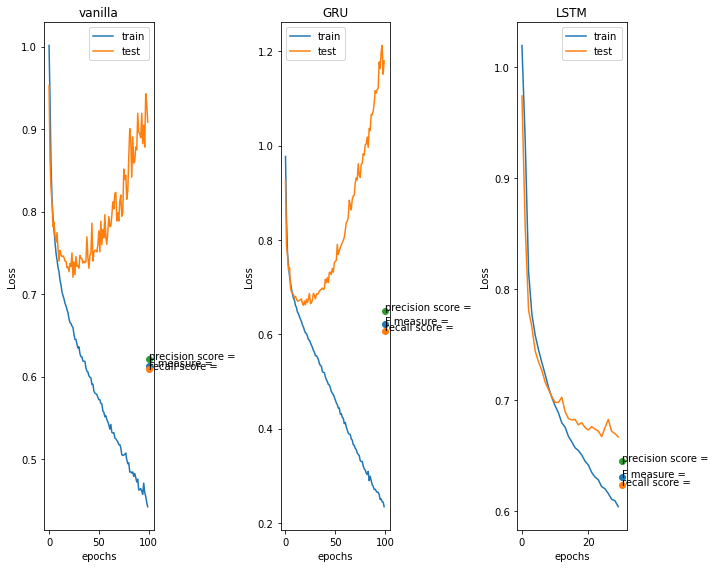

In [20]:


#Initialize dataloader
# plt.subplot(2,2,1)
fig, ax = plt.subplots(1,3)
k=0
store_final=[]
for embd,(vocab_size,vocabulary) in  enumerate(zip([len(TEXT.vocab)],[TEXT.vocab.vectors])):#pick word embedding
  num_classes = 3
  # num_hidden = 50
  # num_layers = 2
  # #Define Hyperparameters
  learning_rate = 1e-4
  #Initialize model, loss, optimizer
  for i,(CELL_TYPE,clip_by_value,num_hidden,num_layers) in enumerate(zip(['vanilla','GRU',"LSTM"],[True,False,True],[50,50,25],[3,3,2])):
    model = TorchtextRNN(d,num_layers, num_hidden,num_classes, CELL_TYPE,vocab_size,vocabulary,bidirectional=True)
    to_device(model,device)
    for j, (loss_func,optimizer) in enumerate(zip([F.cross_entropy],[torch.optim.Adam(model.parameters(), lr=learning_rate)])):#picks a loss and optimiser i use different ones later for to avoid making this convoluted
      train_losses=[]
      test_losses=[]
      final_output=[]
      final_ypred = []
      final_label= []
      if(quick_execution==False):
        if(i==2):
          epochs=30
        else:
          epochs=100
      else:
        epochs=quick_global_epoch
      for epoch in tqdm(range(epochs)):
        model.train()#train mode allows for gradient and hyper parameter optimisation.torch.optim takes model.parameters() so it can know which parameters to tweak and which not
        batch_losses = []
        for batch in train_iterator:
          x_batch, x_batch_lengths = batch.text
          # print( x_batch.shape)
          output = model(x_batch,x_batch_lengths)
          pred_probab = nn.Softmax(dim=1)(output)#activation function
          y_pred = pred_probab.argmax(1)
          loss = loss_func(output, batch.label.long()) #models always output a one hot vector while y_batch is class number i.e 0 1 2
          batch_losses.append(loss.item())
          
          #Delete previously stored gradients
          optimizer.zero_grad()
          #Perform backpropagation starting from the loss calculated in this epoch
          loss.backward()
          if (clip_by_value):
          # Gradient Norm Clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
          else:  
          #Gradient Value Clipping
            nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
          #Update model's weights based on the gradients calculated during backprop
          optimizer.step()
        
        # print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainloader):.5f}")
        train_losses.append(sum(batch_losses)/len(train_iterator))
        with torch.no_grad():
          model.eval()#this eval/test mode will stop the model from training itself for the test dataset by locking down the model parameters and not doing backward probagation
          # scores=[]
          batch_losses = []
          for batch in valid_iterator:
            x_batch, x_batch_lengths = batch.text
            output = model(x_batch,x_batch_lengths)
            pred_probab = nn.Softmax(dim=1)(output)
            y_pred = pred_probab.argmax(1)
            if epoch==epochs-1:#for the final epoch combine the results and store them(the final epoch will have the best results)
              final_output += output
              final_ypred += y_pred
              final_label += batch.label
            loss = loss_func(output,  batch.label.long())
            batch_losses.append(loss.item())
          test_losses.append(sum(batch_losses)/len(valid_iterator))
      store_final.append((final_output,final_ypred,final_label))
      k=k+1
      for metric,metric_name in zip([f1_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ),recall_score (torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ) ,precision_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' )], ["F measure =","recall score =","precision score ="]):
        ax[i].scatter([epochs], [metric])
        ax[i].annotate(metric_name, (epochs, metric))
      ax[i].plot(range(epochs), train_losses)
      ax[i].plot(range(epochs), test_losses)
      ax[i].legend(['train', 'test'])
      ax[i].set_xlabel("epochs")
      ax[i].set_ylabel("Loss")
      ax[i].title.set_text(CELL_TYPE)#plot loss vs epochs graph and point the prediction accuracy scores
fig.set_figwidth(10)
fig.set_figheight(4*2)
plt.tight_layout()
plt.show()

roc curves για τα παραπανω μοντέλα με σείρα απο αριστερά προς δεξιά και  πάνω προς κάτω

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


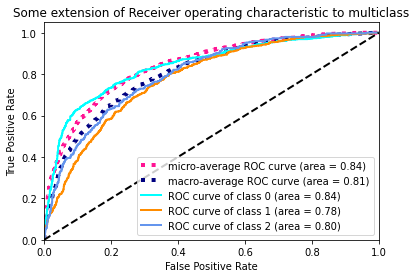

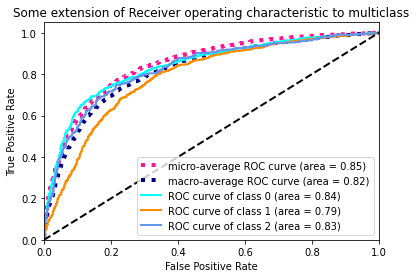

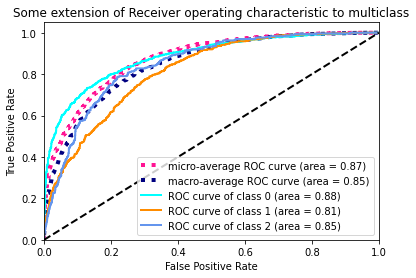

              precision    recall  f1-score   support

  neutral(0)      0.790     0.713     0.749      1065
 anti-vax(1)      0.632     0.730     0.677       921
  pro-vax(2)      0.442     0.385     0.412       296

    accuracy                          0.677      2282
   macro avg      0.621     0.609     0.613      2282
weighted avg      0.681     0.677     0.676      2282

              precision    recall  f1-score   support

  neutral(0)      0.742     0.762     0.752      1065
 anti-vax(1)      0.648     0.704     0.675       921
  pro-vax(2)      0.561     0.358     0.437       296

    accuracy                          0.686      2282
   macro avg      0.650     0.608     0.621      2282
weighted avg      0.681     0.686     0.680      2282

              precision    recall  f1-score   support

  neutral(0)      0.809     0.759     0.783      1065
 anti-vax(1)      0.650     0.745     0.694       921
  pro-vax(2)      0.478     0.368     0.416       296

    accuracy        

In [21]:
def show_roc():
  num_curves=len(store_final)
  for i in range(num_curves):
    final_output,final_ypred,final_label=store_final[i]
    f =[o.tolist() for o in final_output]
    f
    fn = np.array(f)
    fn
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test=label_binarize(final_label, classes=[0, 1, 2])# roc curve function requires one-hot vectors
    y_score=fn
    n_classes=num_classes
    for i in range(n_classes):
        # print(y_test[:, i])#oi ploiades poy einai pragmati tis classis i exoyn 1/true
        # print(y_score[:, i])#oi ploiades poy NOMIZOYN oti einai tis classis i exoyn 1/true
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    # plt.subplot(1, num_curves, i)
    # plt.figure(figsize=(10,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
  plt.show()

def report():
  num_curves=len(store_final)
  for i in range(num_curves):
    final_output,final_ypred,final_label=store_final[i]
    print(classification_report(final_label, final_ypred, digits=3,target_names=['neutral(0)','anti-vax(1)','pro-vax(2)']))

# print(store_final)
show_roc()
report()

##PART 2

In [ ]:
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.twitter.27B.zip','glove.27B.zip') #i load the largest vocabulary for the most accuracy
!unzip "/content/glove.27B.zip" -d $path


Archive:  /content/glove.27B.zip
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.25d.txt  
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.50d.txt  
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.100d.txt  
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.200d.txt  


# Classification with Word2Vec & GloVe
το GloVe εχει έτοιμο λεξιλόγιο και vectors για αυτο ενω το Word2Vec το παράγει απο τα csv δεδόμενων μας.

στο glove οταν δεν υπάρχει μια λεξη στο λεξιλόγιο  της αναθέτω εναν μηδενικο vector για να μην έχει αντίκτυπο στο classification

μια προταση πρεπει να εχει ενα 1xN πινακα οπου N=200 για το GloVe και 100 γία το Word2Vec. μια πρόταση εχει πολλες λεξεις που γυρνανε  1xN vector φτιαχνοντας εναν MxN πίνακα. 


In [22]:
emmbed_dict = {}
d=200
with open(path + 'glove.twitter.27B.' + str(d) + 'd.txt','r', encoding="utf8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

In [23]:
def find_similar_word(emmbedes):
  nearest = sorted(emmbed_dict.keys(), key=lambda word: spatial.distance.euclidean(emmbed_dict[word], emmbedes))
  return nearest
emmbed_dict.get("river", 0.000)
# np.zeros((200,), dtype=float)

array([-7.3568e-01, -1.7927e-01,  1.8122e-01, -1.1934e-01,  5.3740e-01,
        7.2252e-01,  2.6753e-01,  6.2066e-01, -4.8098e-01, -4.2978e-01,
        1.5315e-01,  5.4204e-01, -1.2235e-01,  5.0970e-01, -2.3353e-02,
        4.3671e-01,  5.0077e-01,  5.4246e-02,  7.1848e-01, -7.7348e-01,
        2.7460e-01, -4.3988e-01,  1.6898e-01, -3.0886e-01, -2.2642e-01,
       -1.2224e+00, -5.5304e-01,  8.4110e-02, -2.6801e-01, -3.7397e-01,
       -2.3221e-01,  3.2264e-01,  5.0858e-01,  2.3427e-01,  1.6964e-01,
       -2.1864e-01,  9.1073e-02,  5.3864e-01,  5.8349e-01, -3.1867e-01,
        2.7548e-01,  1.4245e-01, -3.1331e-01, -5.9183e-02,  1.0183e-01,
        2.3288e-02, -1.9689e-01,  3.1934e-01,  3.6827e-01,  4.1610e-01,
       -1.7543e-01, -5.7951e-02,  1.6626e-01,  1.6511e-01,  1.0885e-01,
       -1.8602e-01, -6.1585e-01,  2.9076e-01,  2.3026e-02,  2.9966e-01,
       -7.7732e-01,  9.3240e-01, -6.9943e-02, -1.2402e-01,  9.1285e-01,
        1.4358e-01, -5.6668e-01, -3.8502e-01, -2.8998e-01, -3.88

In [24]:
trainlabel = torch.tensor(train_df['label'])#extract true-false label
testlabel=torch.tensor(validation_set['label'])
sentences = pd.concat([train_df.tweet,validation_set.tweet],ignore_index=True)
nltk.download('punkt')
# simple tokenization
tokens = [nltk.word_tokenize(sentence) for sentence in sentences]
train_tokens = [nltk.word_tokenize(sentences) for sentences in train_df.tweet ]
test_tokens = [nltk.word_tokenize(sentences) for sentences in validation_set.tweet]
w2vmodel = Word2Vec(tokens,
                    seed=32,
                    negative=5,
                    sg=0,
                    min_count=1,
                    window=1)

w2vmodel.build_vocab(tokens, update=True)  # prepare the model vocabulary
w2vmodel.train(train_tokens, total_examples=len(train_tokens), epochs=2)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(383570, 642618)

In [25]:
seq_length = 15
def sequencer(tweet,input_dim):
  sequence=np.concatenate((tweet[:seq_length], np.zeros(( max(seq_length - tweet.shape[0] ,0),input_dim )) ), axis=0)
  return sequence

test_result = 0.0
train_result = 0.0
test_results = []
train_results = []
test_learning_curve = []
train_learning_curve = []
print("Word2Vec")
w2v_traindata = torch.tensor( [sequencer(np.array([w2vmodel.wv.get_vector(word) for word in record]),100)  for record in train_tokens], dtype=torch.float)
w2v_testdata = torch.tensor([sequencer(np.array([w2vmodel.wv.get_vector(word) for word in record]),100) for record in test_tokens], dtype=torch.float)


print()

print("Glove")
glv_traindata = torch.tensor([sequencer(np.array([emmbed_dict.get(tokenize(word),np.zeros((200,), dtype=float)) for word in record]),200) for record in train_tokens], dtype=torch.float)
glv_testdata = torch.tensor([sequencer(np.array([emmbed_dict.get(tokenize(word),np.zeros((200,), dtype=float)) for word in record]),200) for record in test_tokens], dtype=torch.float)



Word2Vec


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  del sys.path[0]



Glove


In [26]:
class RNN(nn.Module):
    """
    Wrapper class that will hold the interface for VanillaRNN, LSTMs and GRUs
    """
    
    def __init__(self,num_features,num_layers, num_hidden, num_classes, cell_type,bidirectional=True):
        super().__init__()
        cells = {
        "vanilla" : nn.RNN(input_size=num_features, hidden_size=num_hidden, num_layers=num_layers, batch_first=True,bidirectional=bidirectional, dropout=0.25),
        "LSTM"    : nn.LSTM(input_size=num_features, hidden_size=num_hidden, num_layers=num_layers, batch_first=True,bidirectional=bidirectional, dropout=0.40), # for future implementations
        "GRU"     : nn.GRU(input_size=num_features, hidden_size=num_hidden, num_layers=num_layers, batch_first=True,bidirectional=bidirectional, dropout=0.35) # for future implementations
        }
        self.LSTMS=["LSTM"]
        self.num_hidden = num_hidden
        self.D=1+bidirectional
        # Number of hidden layers
        self.num_layers = num_layers
        self.num_features = num_features
        # print(f"Creating RNN with cell: {cell_type}")
        self.cell_type = cell_type
        self.cell = cells[cell_type]
        print(self.cell)
        self.predictor = nn.Linear(num_hidden * self.D , num_classes)
        self._init_weights()
    
    def _init_weights(self):
        for param in self.cell.parameters():
            # Keep track of gradient for backprop
            param.requires_grad_(True)
            # If we deal with weights xavier initialization
            if param.data.ndimension() >= 2:
                nn.init.xavier_uniform_(param.data) #keep variance stability
            # Else is a bias term so all zeros
            else: 
                nn.init.zeros_(param.data)
                
    def forward(self, X):
        h0 = Variable(torch.zeros(self.D * self.num_layers, X.size(0), self.num_hidden))
        c0 = Variable(torch.zeros(self.D * self.num_layers, X.size(0), self.num_hidden))
        # out,( hn,cn )= self.cell(X,(h0,c0))
        if(self.cell_type in self.LSTMS):
          out,( hn,cn )= self.cell(X,(h0,c0))
        else:
          out,( hn )= self.cell(X,(h0))
        # print(out.shape)
        out = self.predictor(out[:, -1, :]) 
        return out

100
RNN(100, 50, num_layers=3, batch_first=True, dropout=0.25, bidirectional=True)


100%|██████████| 100/100 [09:46<00:00,  5.87s/it]


GRU(100, 50, num_layers=3, batch_first=True, dropout=0.25, bidirectional=True)


100%|██████████| 100/100 [23:42<00:00, 14.23s/it]


LSTM(100, 25, num_layers=2, batch_first=True, dropout=0.45, bidirectional=True)


100%|██████████| 30/30 [03:44<00:00,  7.48s/it]


200
RNN(200, 50, num_layers=3, batch_first=True, dropout=0.25, bidirectional=True)


100%|██████████| 100/100 [10:20<00:00,  6.21s/it]


GRU(200, 50, num_layers=3, batch_first=True, dropout=0.25, bidirectional=True)


100%|██████████| 100/100 [24:49<00:00, 14.89s/it]


LSTM(200, 25, num_layers=2, batch_first=True, dropout=0.45, bidirectional=True)


100%|██████████| 30/30 [04:01<00:00,  8.04s/it]


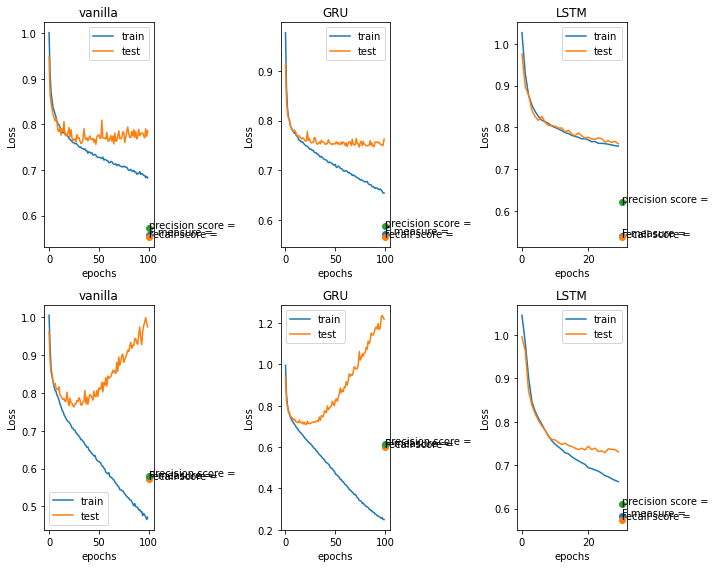

In [27]:


#Initialize dataloader
# plt.subplot(2,2,1)
fig, ax = plt.subplots(2,3)
k=0
store_final=[]
for embd,(traindata,testdata) in  enumerate(zip([w2v_traindata,glv_traindata],[w2v_testdata,glv_testdata])):#pick word embedding
  to_device(traindata,device)
  to_device(testdata,device)
  trainset = torch.utils.data.TensorDataset(traindata, trainlabel)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)#here we shuffle the dataset so the neural network doesnt optimise itself for a specific portion of the dataset(earlier or later) so in each execution the 64 tweets will be different
  testset = torch.utils.data.TensorDataset(testdata, testlabel)#this way we ensure a result isn't dependant on the luck of the order of the tweets
  testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
  trainloader = DeviceDataLoader(trainloader, device)#move data loader and their contents to your preffered device
  testloader = DeviceDataLoader(testloader, device)
  D_in = traindata.shape[2]
  print(D_in)
  # H1 = 128#hyperparameters
  # H2 = 64
  # H3 = 32
  num_classes = 3
  # num_hidden = 50
  # num_layers = 2
  #Define Hyperparameters
  learning_rate = 1e-4
  #Initialize model, loss, optimizer
  for i,(CELL_TYPE,clip_by_value,num_hidden,num_layers) in enumerate(zip(['vanilla','GRU',"LSTM"],[True,False,True],[50,50,25],[3,3,2])):
    model = RNN(D_in,num_layers, num_hidden,num_classes, CELL_TYPE,bidirectional=True)
    to_device(model,device)
    for j, (loss_func,optimizer) in enumerate(zip([F.cross_entropy],[torch.optim.Adam(model.parameters(), lr=learning_rate)])):#picks a loss and optimiser i use different ones later for to avoid making this convoluted
      train_losses=[]
      test_losses=[]
      final_output=[]
      final_ypred = []
      final_label= []
      if(quick_execution==False):
        if(i==2):
          epochs=30
        else:
          epochs=100
      else:
        epochs=quick_global_epoch
      for epoch in tqdm(range(epochs)):
        model.train()#train mode allows for gradient and hyper parameter optimisation.torch.optim takes model.parameters() so it can know which parameters to tweak and which not
        batch_losses = []
        for x_batch, y_batch in trainloader:
          # print( x_batch.shape)
          output = model(x_batch)
          pred_probab = nn.Softmax(dim=1)(output)#activation function
          y_pred = pred_probab.argmax(1)
          loss = loss_func(output, y_batch) #models always output a one hot vector while y_batch is class number i.e 0 1 2
          batch_losses.append(loss.item())
          
          #Delete previously stored gradients
          optimizer.zero_grad()
          #Perform backpropagation starting from the loss calculated in this epoch
          loss.backward()
          if (clip_by_value):
          # Gradient Norm Clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
          else:  
          #Gradient Value Clipping
            nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
          #Update model's weights based on the gradients calculated during backprop
          optimizer.step()
        
        # print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainloader):.5f}")
        train_losses.append(sum(batch_losses)/len(trainloader))
        with torch.no_grad():
          model.eval()#this eval/test mode will stop the model from training itself for the test dataset by locking down the model parameters and not doing backward probagation
          # scores=[]
          batch_losses = []
          for x_batch, y_batch in testloader:
            output = model(x_batch)
            pred_probab = nn.Softmax(dim=1)(output)
            y_pred = pred_probab.argmax(1)
            if epoch==epochs-1:#for the final epoch combine the results and store them(the final epoch will have the best results)
              final_output += output
              final_ypred += y_pred
              final_label += y_batch
            loss = loss_func(output, y_batch)
            batch_losses.append(loss.item())
          test_losses.append(sum(batch_losses)/len(testloader))
      k=k+1
      store_final.append((final_output,final_ypred,final_label))
      for metric,metric_name in zip([f1_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ),recall_score (torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ) ,precision_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' )], ["F measure =","recall score =","precision score ="]):
        ax[embd][i].scatter([epochs], [metric])
        ax[embd][i].annotate(metric_name, (epochs, metric))
      ax[embd][i].plot(range(epochs), train_losses)
      ax[embd][i].plot(range(epochs), test_losses)
      ax[embd][i].legend(['train', 'test'])
      ax[embd][i].set_xlabel("epochs")
      ax[embd][i].set_ylabel("Loss")
      ax[embd][i].title.set_text(CELL_TYPE)#plot loss vs epochs graph and point the prediction accuracy scores
fig.set_figwidth(10)
fig.set_figheight(4*2)
plt.tight_layout()
plt.show()

roc curves για τα παραπανω μοντέλα με σείρα απο αριστερά προς δεξιά και  πάνω προς κάτω

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in 

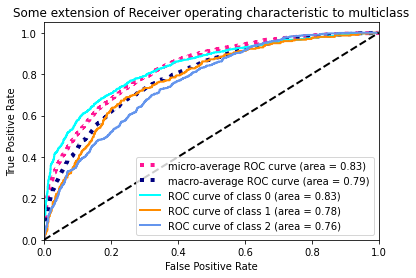

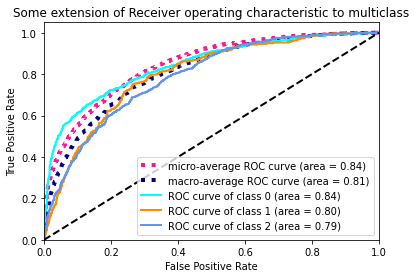

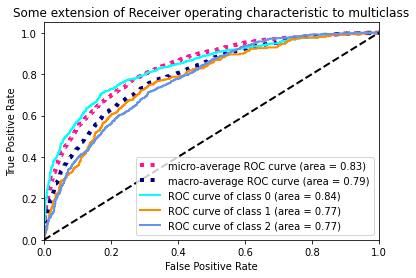

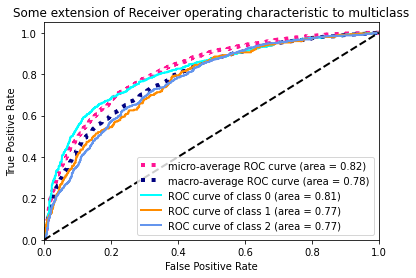

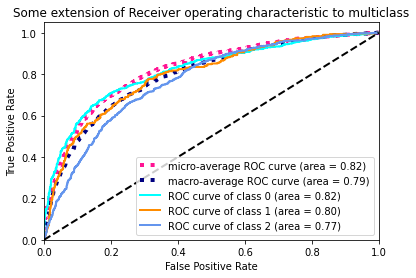

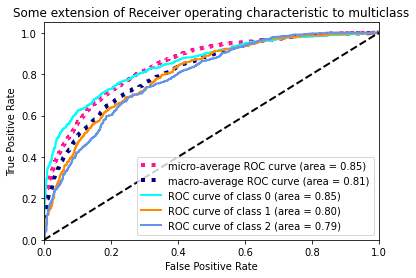

              precision    recall  f1-score   support

  neutral(0)      0.769     0.668     0.715      1065
 anti-vax(1)      0.368     0.274     0.314       296
  pro-vax(2)      0.582     0.719     0.643       921

    accuracy                          0.637      2282
   macro avg      0.573     0.553     0.557      2282
weighted avg      0.642     0.637     0.634      2282

              precision    recall  f1-score   support

  neutral(0)      0.747     0.739     0.743      1065
 anti-vax(1)      0.403     0.274     0.326       296
  pro-vax(2)      0.612     0.683     0.645       921

    accuracy                          0.656      2282
   macro avg      0.587     0.565     0.572      2282
weighted avg      0.648     0.656     0.650      2282

              precision    recall  f1-score   support

  neutral(0)      0.720     0.762     0.741      1065
 anti-vax(1)      0.538     0.142     0.225       296
  pro-vax(2)      0.609     0.711     0.656       921

    accuracy        

In [28]:
show_roc()
report()